# For Colab

In [1]:
# --- always get latest repo state in Colab ---
import os, sys, subprocess

REPO_URL  = "https://github.com/Wmeesena/Safe_Start.git"
REPO_ROOT = "/content/Safe_Start"     # repo root
WORKDIR   = os.path.join(REPO_ROOT, "MAGIC")
BRANCH    = "main"

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

if not os.path.isdir(REPO_ROOT):
    run(["git", "clone", "--depth", "1", "--branch", BRANCH, REPO_URL, REPO_ROOT])
else:
    run(["git", "-C", REPO_ROOT, "fetch", "origin"])
    run(["git", "-C", REPO_ROOT, "checkout", BRANCH])
    run(["git", "-C", REPO_ROOT, "reset", "--hard", f"origin/{BRANCH}"])

# (optional) submodules
# run(["git", "-C", REPO_ROOT, "submodule", "update", "--init", "--recursive"])

# Set working dir and import path
os.chdir(WORKDIR if os.path.isdir(WORKDIR) else REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())
!git -C {REPO_ROOT} rev-parse --abbrev-ref HEAD
!git -C {REPO_ROOT} rev-parse HEAD

# installs
%pip install -q ucimlrepo


CWD: /content/Safe_Start/MAGIC


# Setup

In [118]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import torch
from src.models.mlp import MLP
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from src.train import pretrain,  joint_train, train_all
from src.eval import evaluate_avg_accuracy, evaluate_robust, eval_one, eval_all
from src.utils import pct, pct_ci
from src.plots import plot_loss_multi, plot_all_loss
from src.data import load_magic_data

# %load_ext autoreload
# %autoreload 2


# Data

In [119]:
SIGMA = 40.0
SAMPLES_EVAL = 10000
SAMPLES_TRAIN = 1000
GAMMA = 1000.
NUM_EPOCHS = 3

In [120]:
X_train, y_train, X_test, y_test = load_magic_data()

In [121]:
X_train.device

device(type='cpu')

# Pretrain

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [132]:
model = MLP(input_size=X_train.shape[1]).to(device)
pre_model = pretrain(X_train,y_train, model, num_epochs=1000)

/Users/wasinmeesena/Desktop/Academic/Research/On Going/rare-event/Management_Science/MAGIC/src/train.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  # Define the loss function and optimizer
/Users/wasinmeesena/Desktop/Academic/Research/On Going/rare-event/Management_Science/MAGIC/src/train.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  optimizer.zero_grad()


In [133]:
metrics = {}  # metrics[(cfg, opt)] = dict(...)
metrics[("pre","adam")] = eval_one( pre_model, X_test, y_test, SIGMA, SAMPLES_EVAL)


Accuracy: 86.47%  (CI 95%: [85.38%, 87.49%])


# Training

In [ ]:
results = train_all(X_train, y_train,pre_model, NUM_EPOCHS, GAMMA, SAMPLES_TRAIN, SIGMA )


Training naive with adam...

Training safe with adam...

Training safe_neg with adam...

Training naive with sgd...

Training safe with sgd...

Training safe_neg with sgd...


# Results

## Loss Trajectories

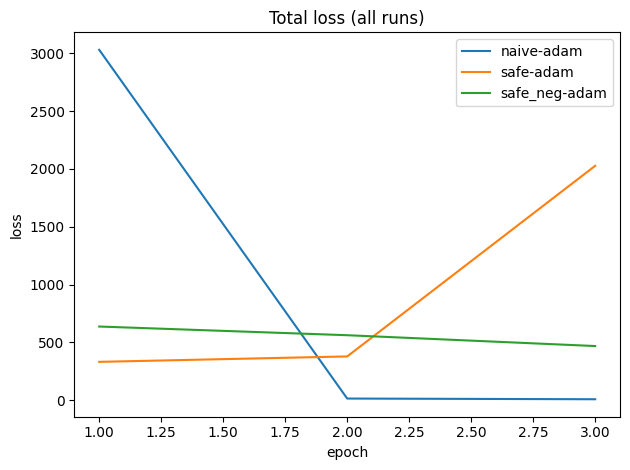

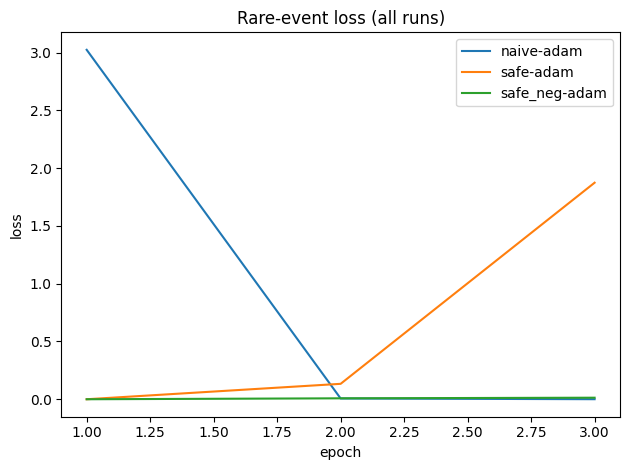

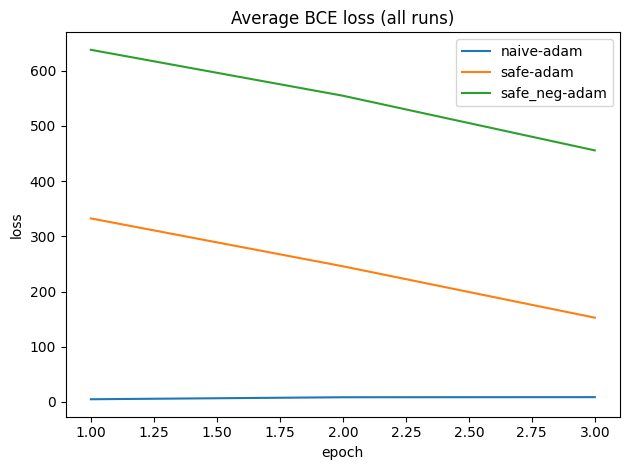

In [ ]:
plot_all_loss(results)

## Accuracies

In [ ]:
eval_all(results, X_test, y_test, SIGMA, 1, metrics)

Accuracy: 63.48%  (CI 95%: [61.98%, 64.96%])
Robust Accuracy: 63.47015%  (CI 95%: [62.12655%, 64.93812%])
Conditional Robust Accuracy: 99.96082%  (CI 95%: [99.90204%, 100.00000%])
Accuracy: 63.48%  (CI 95%: [61.98%, 64.96%])
Robust Accuracy: 63.48259%  (CI 95%: [62.11443%, 64.95025%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 69.23%  (CI 95%: [67.78%, 70.64%])
Robust Accuracy: 69.62687%  (CI 95%: [68.27114%, 70.92040%])
Conditional Robust Accuracy: 98.40100%  (CI 95%: [98.02327%, 98.74236%])
Accuracy: 63.48%  (CI 95%: [61.98%, 64.96%])
Robust Accuracy: 63.48259%  (CI 95%: [62.11443%, 64.95025%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 36.52%  (CI 95%: [35.04%, 38.02%])
Robust Accuracy: 36.50497%  (CI 95%: [35.03700%, 37.88557%])
Conditional Robust Accuracy: 99.96594%  (CI 95%: [99.89782%, 100.00000%])
Accuracy: 36.52%  (CI 95%: [35.04%, 38.02%])
Robust Accuracy: 36.51741%  (CI 95%: [35.04975%, 37.